# Phase 1-3: Branch County PCA

•	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

# Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731
3,2022-01-31,Boone High School,1,10,2,8,30,9,80,21,59
4,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551


In [3]:
# print unique values for BranchCategory and their counts
print(branch_level_data['BranchCategory'].value_counts())

BranchCategory
MetroWest                    19
Sanford                      19
Oak Ridge High School        19
Ocoee High School            19
Orange City                  19
Oviedo                       19
Pine Hills                   19
Poinciana                    19
Poinciana High School        19
Seminole State               19
Altamonte Springs            19
South Orlando                19
St. Cloud                    19
St. Cloud High School        19
The Loop                     19
Timber Creek High School     19
UCF Campus                   19
Virtual Branch               19
Mills                        19
Winter Garden                19
Merritt Island               19
Longwood                     19
Apopka                       19
Boone High School            19
Clermont                     19
Colonial High School         19
Downtown Campus              19
East Orlando                 19
Edgewater High School        19
Eustis                       19
Fern Park                

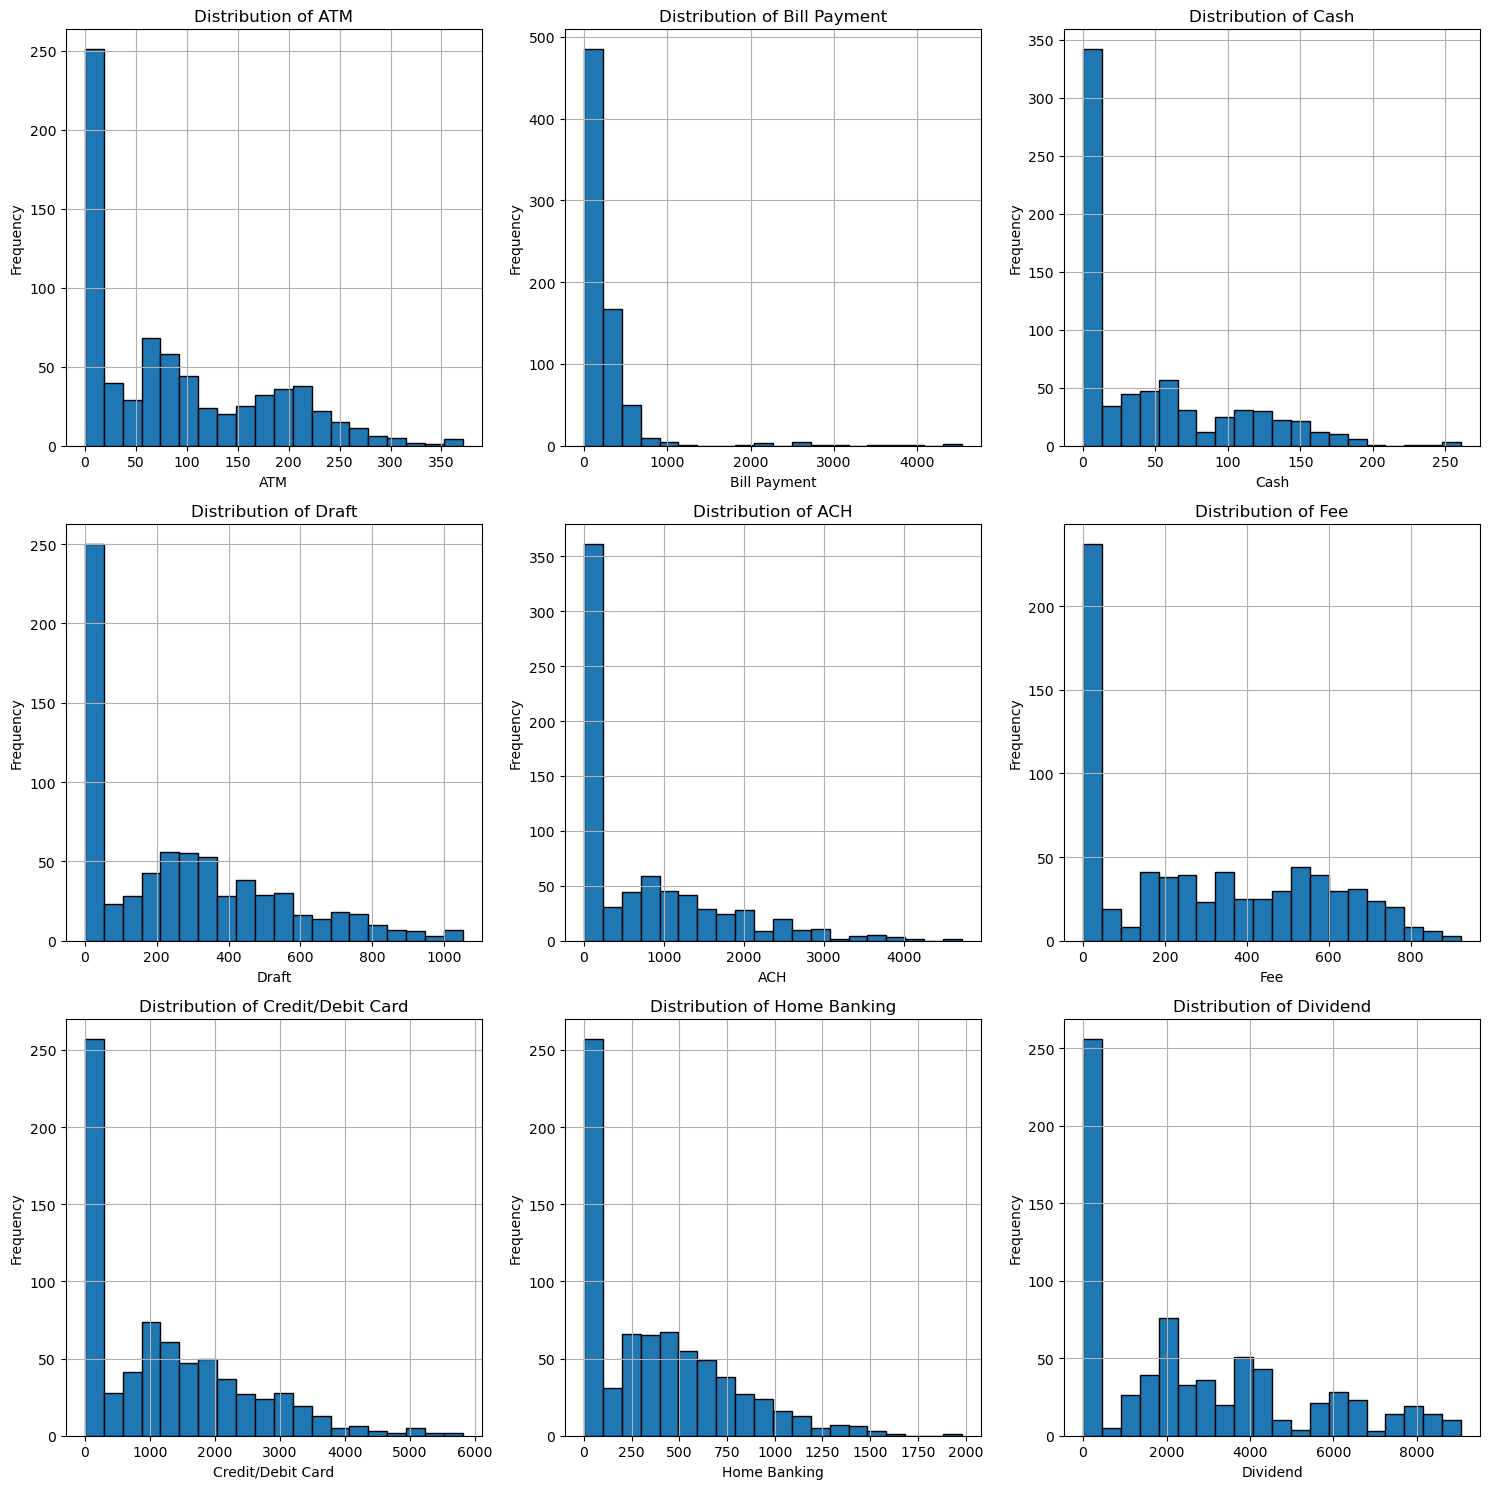

In [4]:
# Plot distribution graphs for each column
num_columns = len(branch_level_data.iloc[:, 2:11].columns)
num_rows = (num_columns - 1) // 3 + 1  # Adjust the number of rows based on the number of columns

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

for i, column in enumerate(branch_level_data.iloc[:, 2:11].columns):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    ax.hist(branch_level_data[column], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [5]:
# print unique values for EOM_TRANS_DATE
print(branch_level_data.EOM_TRANS_DATE.unique())

['2022-01-31' '2022-02-28' '2022-03-31' '2022-04-30' '2022-05-31'
 '2022-06-30' '2022-07-31' '2022-08-31' '2022-09-30' '2022-10-31'
 '2022-11-30' '2022-12-31' '2023-01-31' '2023-02-28' '2023-03-31'
 '2023-04-30' '2023-05-31' '2023-06-30' '2023-07-31']


# Data Preprocessing

In [6]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
4     2022-01-31                  Clermont  143           482   103    499   
6     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
4  1940  539               1834           580      4551  
6   134   78                227            47       275  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0

In [7]:
import pandas as pd

# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [8]:
import pandas as pd

# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
branch_level_data.head()


,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,County,Revenue_Per_County
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14,Orange,6968835122
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650,Seminole,1830400546
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731,Orange,6968835122
3,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551,Lake,1003940427
4,2022-01-31,Downtown Campus,27,35,12,62,134,78,227,47,275,Orange,6968835122


In [9]:
# Dropping unnecessary columns
pre_normalized_df = branch_level_data.drop(['EOM_TRANS_DATE', 'BranchCategory', 'County', 'Revenue_Per_County'], axis=1)
pre_normalized_df.head()

,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,0,3,0,28,5,20,6,4,14
1,98,394,64,469,1589,416,1642,646,3650
2,198,540,132,705,2219,560,1983,724,5731
3,143,482,103,499,1940,539,1834,580,4551
4,27,35,12,62,134,78,227,47,275


In [10]:
from sklearn.preprocessing import StandardScaler

# Create the Scaler object
scaler = StandardScaler()

# Fit the data on the scaler object
normalized_df = scaler.fit_transform(pre_normalized_df)

# Convert the normalized DataFrame into a DataFrame
normalized_df = pd.DataFrame(normalized_df, columns=pre_normalized_df.columns)
# normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.head()

,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,-1.449119,-0.617278,-1.138159,-1.348628,-1.026666,-1.596365,-1.436047,-1.445617,-1.484872
1,-0.279600,0.138588,0.004137,0.433753,0.592510,0.099428,-0.040356,0.380911,0.030027
2,0.913787,0.420829,1.217827,1.387589,1.236501,0.716080,0.250555,0.602826,0.897052
3,0.257424,0.308706,0.700224,0.555003,0.951305,0.626152,0.123441,0.193137,0.405418
4,-1.126905,-0.555417,-0.923979,-1.211211,-0.894802,-1.347991,-1.247509,-1.323280,-1.376130


# PCA Analysis

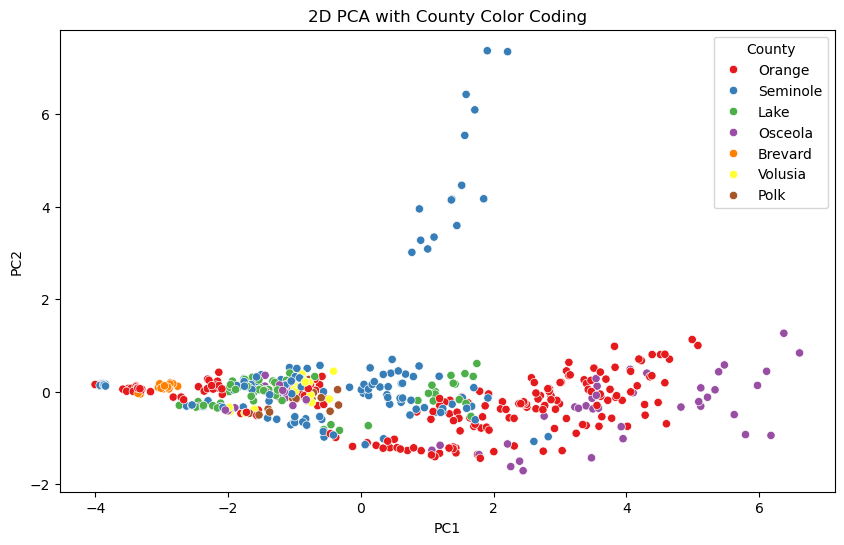

In [11]:
# Apply 2D PCA
from sklearn.decomposition import PCA


pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(normalized_df)

# Create a DataFrame for 2D PCA results
pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
pca_df_2d['County'] = branch_level_data['County']

# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_2d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [12]:
# Print the explained variance ratio
explained_variance_ratio = pca_2d.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.73354733 0.10260918]


In [13]:
# Visualize the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.73354733 0.83615651]


In [14]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca_2d.components_, columns=normalized_df.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking         0.375052
Draft                0.369809
Fee                  0.369386
Dividend             0.362099
ATM                  0.340491
Credit/Debit Card    0.334605
Cash                 0.320927
ACH                  0.313852
Bill Payment         0.160074
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment         0.866065
ACH                  0.299259
Draft                0.050294
Home Banking         0.023659
Cash                -0.019683
Dividend            -0.099272
Fee                 -0.121951
Credit/Debit Card   -0.228182
ATM                 -0.283029
Name: PC2, dtype: float64


In [15]:
# Apply 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(normalized_df)

# Create a DataFrame for 3D PCA results
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['County'] = branch_level_data['County']

# Plot 3D PCA with Plotly
fig = px.scatter_3d(pca_df_3d, x='PC1', y='PC2', z='PC3', color='County', labels={'County': 'County'}, 
                    title='3D PCA with County Color Coding', opacity=0.7, width=1100, height=800,
                    color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker_size=5)
fig.update_layout(legend_title_text='County', legend=dict(yanchor="top", y=0.79, xanchor="left", x=0.01))

# Show the interactive 3D plot
fig.show()

In [16]:
# Print the explained variance ratio
explained_variance_ratio = pca_3d.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.73354733 0.10260918 0.080207  ]


In [17]:
# Visualize the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.73354733 0.83615651 0.91636351]


In [18]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca_3d.components_, columns=normalized_df.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking         0.375052
Draft                0.369809
Fee                  0.369386
Dividend             0.362099
ATM                  0.340491
Credit/Debit Card    0.334605
Cash                 0.320927
ACH                  0.313852
Bill Payment         0.160074
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment         0.866065
ACH                  0.299259
Draft                0.050294
Home Banking         0.023659
Cash                -0.019683
Dividend            -0.099272
Fee                 -0.121951
Credit/Debit Card   -0.228182
ATM                 -0.283029
Name: PC2, dtype: float64

Feature Loadings for PC3:
Credit/Debit Card    0.473294
Bill Payment         0.382239
Dividend             0.262590
Fee                  0.137018
ATM                  0.096695
Home Banking        -0.014182
Draft               -0.217140
Cash                -0.480137
ACH                 -0.504902
Name: PC3, dtype: float64


In [19]:
pca_df_3d['Revenue_Per_County'] = branch_level_data['Revenue_Per_County']
pca_df_3d.head()

,PC1,PC2,PC3,County,Revenue_Per_County
0,-3.928480,0.158439,-0.286203,Orange,6968835122
1,0.451635,0.401322,-0.372388,Seminole,1830400546
2,2.569815,0.302398,-0.817412,Orange,6968835122
3,1.357435,0.353113,-0.546204,Lake,1003940427
4,-3.407836,0.081765,-0.280570,Orange,6968835122


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X = pca_df_3d.drop(columns=['Revenue_Per_County','County'])
y = pca_df_3d['Revenue_Per_County']

# Convert 'Revenue_Per_County' to numeric, in case it's not
y = pd.to_numeric(y, errors='coerce')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Coefficient of Determination (R^2):', r2_score(y_test, y_pred))

# Optionally, print the coefficients for each feature
feature_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(feature_coefficients)

Mean Squared Error: 6.396534929290373e+18
Coefficient of Determination (R^2): 0.0794782305544427
      Coefficient
PC1  1.410960e+08
PC2 -4.586442e+08
PC3 -5.321143e+07


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable  VIF
0      PC1  1.0
1      PC2  1.0
2      PC3  1.0
